In [91]:
import itertools

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib import pyplot as plt

In [92]:
# Due to the dependencies on other packages, gammapy v0.19 is installed
# in the current magic-cta-pipe environment, but it is already outdated.
# In order to use the latest features, such as dynamic theta cuts and
# the wobble region finder, please run this notebook with a different
# environment where the newer versions of gammapy (v0.20.*) is installed.

import gammapy

print(f"gammapy: v{gammapy.__version__}")

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from regions import CircleSkyRegion, PointSkyRegion

gammapy: v0.20.1


In [93]:
# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "--"}
)

# Get the default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Load DL3 data

In [94]:
# ================
# === Settings ===
# ================

input_dir = '/fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_int/'
    
input_dir_1 = '/fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_wgt/'

# === Main ===
# ============

print(f"Input directory: {input_dir}")
print(f"Input directory: {input_dir_1}")

double = True
if input_dir_1=='':
    double = False

data_store = DataStore.from_dir(input_dir)
if double:
    data_store_1 = DataStore.from_dir(input_dir_1)
# Show the observation table
data_store.obs_table


Input directory: /fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_dyn_int/
Input directory: /fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_dyn_wgt_int/


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes10,bytes10
2923,2020-11-18,23:35:47.415,2020-11-18,23:52:39.650,83.96696805679441,22.24638287152439,45.06171120796383,44.93828879203617,86.40431692412777,83.63333333,22.01333333,1605742547.414514,1605743559.649549,451.3736107349396,1012.235034465789,409.0913326624333,0.906325321049095,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
2924,2020-11-18,23:56:14.698,2020-11-19,00:15:55.933,83.26503262048294,21.7876915585711,40.10371827458638,49.89628172541362,89.6596903830588,83.63333333,22.01333333,1605743774.698224,1605744955.932863,536.2971684932709,1181.234639644619,487.0149766340357,0.9081065596566663,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3093,2020-12-07,23:34:47.190,2020-12-07,23:36:13.672,83.97885081403817,22.24526920857109,28.896547521311618,61.10345247868838,95.75666061818394,83.63333333,22.01333333,1607384087.190233,1607384173.672199,39.02381253242493,86.48196649551103,36.69248074225411,0.9402587384758034,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3265,2020-12-15,21:27:18.415,2020-12-15,21:41:43.146,83.96475780330954,22.247863563275,49.9494782005039,40.0505217994961,84.08107653962642,83.63333333,22.01333333,1608067638.414856,1608068503.145767,472.7662608623505,864.7309117317188,449.7320408635144,0.9512777837470456,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3266,2020-12-15,21:43:24.497,2020-12-15,21:57:30.340,83.26300698928598,21.7877022954978,45.96227389775927,44.03772610224073,86.64186055227022,83.63333333,22.01333333,1608068604.496795,1608069450.340243,462.2223224639893,845.8434472083973,440.4028394825901,0.9527943980180684,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3267,2020-12-15,21:59:19.731,2020-12-15,22:12:55.664,83.96675054673734,22.24606302455202,42.93517607753816,47.06482392246184,87.45572611833191,83.63333333,22.01333333,1608069559.731362,1608070375.663918,439.3872592449188,815.932556152341,418.9587482320345,0.9535068198199681,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,2021-02-13,23:09:15.761,2021-02-13,23:26:01.783,83.28785259632826,21.78673659083378,27.93920269216776,62.06079730783224,262.4862245311674,83.63333333,22.01333333,1613257755.761256,1613258761.783382,407.7805027961731,1006.022126674656,392.9189927423401,0.9635551235237417,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2


In [95]:
# ================
# === Settings ===
# ================



obs_ids = None   # `None` means "all" observations

# ============
# === Main ===
# ============

observations = data_store.get_observations(obs_ids, required_irf="point-like")
if double:
    observations_1 = data_store_1.get_observations(obs_ids, required_irf="point-like")
print(observations)




Observations
Number of observations: 16
Observation

	obs id            : 2923 
 	tstart            : 59171.98
	tstop             : 59171.99
	duration          : 1012.24 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 9.4%
Observation

	obs id            : 2924 
 	tstart            : 59172.00
	tstop             : 59172.01
	duration          : 1181.23 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 9.2%
Observation

	obs id            : 3093 
 	tstart            : 59190.98
	tstop             : 59190.98
	duration          : 86.48 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 6.0%
Observation

	obs id            : 3265 
 	tstart            : 59198.89
	tstop             : 59198.90
	duration          : 864.73 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 4.9%
Observation

	obs id            : 3266 
 	tstart            : 59198.90
	tstop             : 59198.91
	duration          : 845.84 s
	pointing (icrs)   : 83.3 deg, 21.8 

# Define a target region

In [96]:
# Get metadata from the first observation
observation = observations[0]

event_meta = observation.events.table.meta
aeff_meta = observation.aeff.meta

# Define a target position
target_position = SkyCoord(
    u.Quantity(event_meta["RA_OBJ"], u.deg),
    u.Quantity(event_meta["DEC_OBJ"], u.deg),
    frame="icrs",
)

if "RAD_MAX" in aeff_meta:
    # Get the global theta cut used for creating the IRFs
    on_region_radius = aeff_meta["RAD_MAX"] * u.deg
    
    # Use the circle sky region to apply the global theta cut
    on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
    
else:
    # Use the point sky region to apply dynamic theta cuts
    on_region = PointSkyRegion(target_position)
    
print(on_region)

Region: PointSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 22.01333333)>


In [97]:
if double:
    # Get metadata from the first observation
    observation_1 = observations_1[0]

    event_meta_1 = observation_1.events.table.meta
    aeff_meta_1 = observation_1.aeff.meta

    # Define a target position
    target_position_1 = SkyCoord(
        u.Quantity(event_meta["RA_OBJ"], u.deg),
        u.Quantity(event_meta["DEC_OBJ"], u.deg),
        frame="icrs",
    )

    if "RAD_MAX" in aeff_meta:
        # Get the global theta cut used for creating the IRFs
        on_region_radius = aeff_meta["RAD_MAX"] * u.deg

        # Use the circle sky region to apply the global theta cut
        on_region_1 = CircleSkyRegion(center=target_position, radius=on_region_radius)

    else:
        # Use the point sky region to apply dynamic theta cuts
        on_region_1 = PointSkyRegion(target_position_1)

    print(on_region_1)

Region: PointSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 22.01333333)>


# Run the data reduction chain

In [98]:
# ================
# === Settings ===
# ================

energy_min = "0.030 TeV"
energy_max = "30. TeV"
n_bins_pdec = 5

true_energy_min = "0.01 TeV"
true_energy_max = "100 TeV"
n_bins_pdec_true = 10

n_off_regions = 3

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(
    energy_min,
    energy_max,
    nbin=n_bins_pdec,
    per_decade=True,
    name="energy",
)

energy_axis_true = MapAxis.from_energy_bounds(
    true_energy_min,
    true_energy_max,
    nbin=n_bins_pdec_true,
    per_decade=True,
    name="energy_true",
)

print("Energy axis:")
print(energy_axis.edges)

on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

# Create a spectrum dataset maker
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"],
    use_region_center=True,
)

# Create a background maker
print(f"\nNumber of OFF regions: {n_off_regions}")

region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# Create a safe mask maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=3)

Energy axis:
[3.00000000e-02 4.75467958e-02 7.53565929e-02 1.19432151e-01
 1.89287203e-01 3.00000000e-01 4.75467958e-01 7.53565929e-01
 1.19432151e+00 1.89287203e+00 3.00000000e+00 4.75467958e+00
 7.53565929e+00 1.19432151e+01 1.89287203e+01 3.00000000e+01] TeV

Number of OFF regions: 3


In [99]:
if double:
    on_geom_1 = RegionGeom.create(region=on_region_1, axes=[energy_axis])
    dataset_empty_1 = SpectrumDataset.create(geom=on_geom_1, energy_axis_true=energy_axis_true)
    # Create a spectrum dataset maker
    dataset_maker_1 = SpectrumDatasetMaker(
        containment_correction=False,
        selection=["counts", "exposure", "edisp"],
        use_region_center=True,
    )

    # Create a background maker
    print(f"\nNumber of OFF regions: {n_off_regions}")

    region_finder_1 = WobbleRegionsFinder(n_off_regions=n_off_regions)
    bkg_maker_1 = ReflectedRegionsBackgroundMaker(region_finder=region_finder_1)

    # Create a safe mask maker
    safe_mask_maker_1 = SafeMaskMaker(methods=["aeff-max"], aeff_percent=3)


Number of OFF regions: 3


First sample

In [100]:
datasets = Datasets()

counts = Map.create(skydir=target_position, width=3)

# Loop over every observation
print("Running the makers...")

n_observations = len(observations)

for i_obs, observation in enumerate(observations):
    
    if (i_obs % 10) == 0:
        print(f"{i_obs}/{n_observations}")
    
    obs_id = observation.obs_id
    
    # Fill the number of events in the map
    counts.fill_events(observation.events)

    # Run the makers to the observation data
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

print(f"{n_observations}/{n_observations}")

# Get the information table
info_table = datasets.info_table(cumulative=True)
print(datasets.energy_ranges)
# Show the table
info_table

Running the makers...
0/16


Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '2923'.
ReflectedRegionsBackgroundMaker failed. Setting 2923 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '2924'.
ReflectedRegionsBackgroundMaker failed. Setting 2924 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '3093'.
ReflectedRegionsBackgroundMaker failed. Setting 3093 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '3265'.
ReflectedRegionsBackgroundMaker failed. Setting 3265 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackground

10/16


Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '3635'.
ReflectedRegionsBackgroundMaker failed. Setting 3635 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '3636'.
ReflectedRegionsBackgroundMaker failed. Setting 3636 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '4069'.
ReflectedRegionsBackgroundMaker failed. Setting 4069 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '4070'.
ReflectedRegionsBackgroundMaker failed. Setting 4070 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackground

16/16


/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/stats/counts_statistic.py:348: RuntimeWarning: invalid value encountered in float_scalars
  alpha = self.n_bkg.sum(axis=axis) / n_off
/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/stats/counts_statistic.py:348: RuntimeWarning: invalid value encountered in float_scalars
  alpha = self.n_bkg.sum(axis=axis) / n_off
/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/stats/counts_statistic.py:348: RuntimeWarning: invalid value encountered in float_scalars
  alpha = self.n_bkg.sum(axis=axis) / n_off
/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/stats/counts_statistic.py:348: RuntimeWarning: invalid value encountered in float_scalars
  alpha = self.n_bkg.sum(axis=axis) / n_off
/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/

(<Quantity [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
           0.03, 0.03, 0.03, 0.03, 0.03, 0.03] TeV>, <Quantity [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30.] TeV>)


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,1012.2350344657898,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,2193.4696741104126,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,2279.9516406059265,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,3144.6825523376465,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,3990.525999546051,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,4806.458555698395,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,205,157.3333282470703,13.391507100585121,47.66667175292969,87.00000751018501,87.00000751018501,nan,6010.5302734375,77142728.0,648.9675350018621,8971.379978656769,0.31588637172645595,0.07345000971858001,0.2424363620078759,15,14,wstat,252.20408750019848,143,14.0,41.999996185302734,0.3333333730697632


Seconda sample

In [101]:
if double :
    datasets_1 = Datasets()

    counts_1 = Map.create(skydir=target_position_1, width=3)

    # Loop over every observation
    print("Running the makers...")

    n_observations_1 = len(observations_1)

    for i_obs, observation in enumerate(observations_1):

        if (i_obs % 10) == 0:
            print(f"{i_obs}/{n_observations_1}")

        obs_id = observation.obs_id

        # Fill the number of events in the map
        counts_1.fill_events(observation.events)

        # Run the makers to the observation data
        dataset = dataset_maker_1.run(dataset_empty_1.copy(name=str(obs_id)), observation)
        dataset_on_off = bkg_maker_1.run(dataset, observation)
        dataset_on_off = safe_mask_maker_1.run(dataset_on_off, observation)

        datasets_1.append(dataset_on_off)

    print(f"{n_observations_1}/{n_observations_1}")

    # Get the information table
    info_table_1 = datasets_1.info_table(cumulative=True)
    print(datasets_1.energy_ranges)
    
    # Show the table
    info_table_1

Running the makers...
0/16


Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '2923'.
ReflectedRegionsBackgroundMaker failed. Setting 2923 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '2924'.
ReflectedRegionsBackgroundMaker failed. Setting 2924 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '3093'.
ReflectedRegionsBackgroundMaker failed. Setting 3093 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '3265'.
ReflectedRegionsBackgroundMaker failed. Setting 3265 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackground

10/16


Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '3636'.
ReflectedRegionsBackgroundMaker failed. Setting 3636 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '4069'.
ReflectedRegionsBackgroundMaker failed. Setting 4069 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '4070'.
ReflectedRegionsBackgroundMaker failed. Setting 4070 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '4071'.
ReflectedRegionsBackgroundMaker failed. Setting 4071 mask to False.
Found overlapping on/off regions, choose less off regions
ReflectedRegionsBackground

16/16


/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/stats/counts_statistic.py:348: RuntimeWarning: invalid value encountered in float_scalars
  alpha = self.n_bkg.sum(axis=axis) / n_off
/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/stats/counts_statistic.py:348: RuntimeWarning: invalid value encountered in float_scalars
  alpha = self.n_bkg.sum(axis=axis) / n_off
/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/stats/counts_statistic.py:348: RuntimeWarning: invalid value encountered in float_scalars
  alpha = self.n_bkg.sum(axis=axis) / n_off
/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/lib/python3.8/site-packages/gammapy/stats/counts_statistic.py:348: RuntimeWarning: invalid value encountered in float_scalars
  alpha = self.n_bkg.sum(axis=axis) / n_off
/fefs/home/elisa.visentin/mambaforge-pypy3/envs/gammapy-v0.20.1/

(<Quantity [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
           0.03, 0.03, 0.03, 0.03, 0.03, 0.03] TeV>, <Quantity [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30.] TeV>)


In [102]:
info_table_1

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,1012.2350344657898,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,2193.4696741104126,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,2279.9088938236237,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,3144.2763636112213,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,3990.119810819626,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,4806.05236697197,nan,nan,nan,15,0,wstat,0.0,0,0.0,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,520,407.6666564941406,22.06737639123549,112.33333587646484,214.25001134350867,214.25001134350867,nan,7571.4482421875,240577728.0,1618.325309537474,8970.973789930344,0.32131982175364904,0.06941332204003552,0.2519064949992372,15,14,wstat,640.565165343449,337,14.0,42.0,0.3333333432674408


Some plots (first sample)

AttributeError: 'NoneType' object has no attribute 'plot_region'

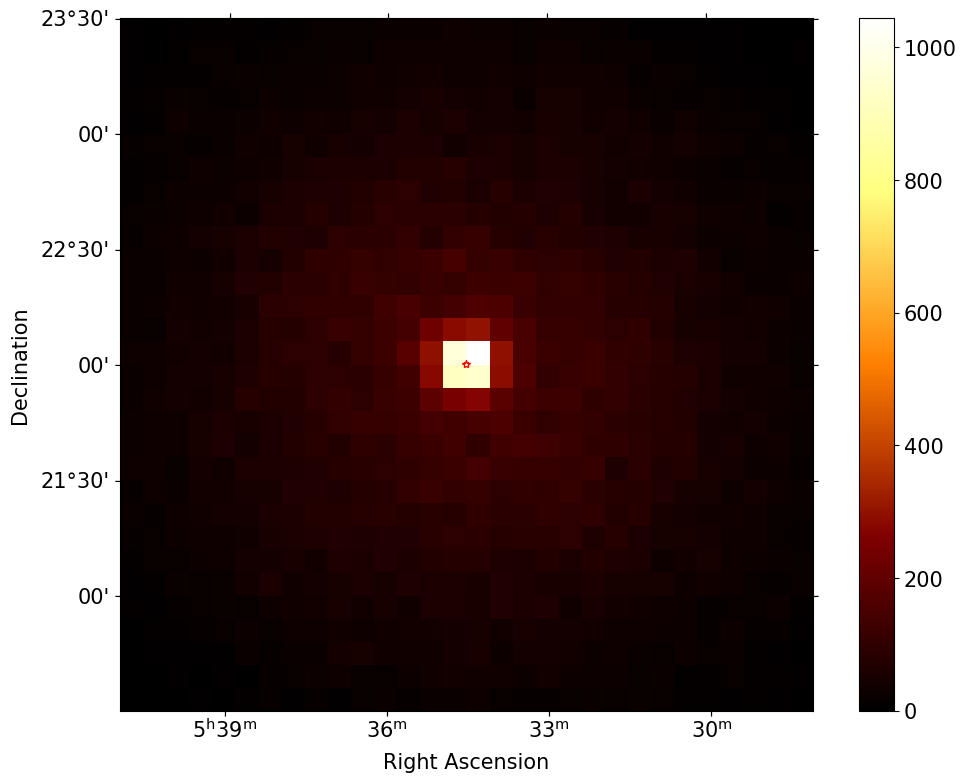

In [103]:
plt.figure()

# Plot the count map
ax = counts.plot(add_cbar=True)

# Plot the ON position
on_geom.plot_region(ax=ax, edgecolor="red")

# Plot the OFF positions (only the first part of observations)
if n_observations < 10:
    plot_spectrum_datasets_off_regions(datasets, ax)
else:
    plot_spectrum_datasets_off_regions(datasets[0:10], ax)

ax.grid()

In [ ]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Plot the number of events along the livetime
plt.subplot2grid(grid, (0, 0))
plt.xlabel("Livetime [hour]")
plt.ylabel("Number of events")

plt.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    linestyle="--",
    label="Excess",
)

plt.plot(
    info_table["livetime"].to("h"),
    info_table["background"],
    marker="o",
    linestyle="--",
    label="Background",
)

plt.grid()
plt.legend()

# Plot the significance along the livetime
plt.subplot2grid(grid, (0, 1))
plt.xlabel("Livetime [hour]")
plt.ylabel("Sqrt(TS)")

plt.plot(
    info_table["livetime"].to("h"), info_table["sqrt_ts"], marker="o", linestyle="--"
)

plt.grid()

# Fit the spectrum

In [ ]:
source_name="Crab Nebula"

spectral_model = LogParabolaSpectralModel(
    amplitude=u.Quantity(5e-12, unit="cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=u.Quantity(1, unit="TeV"),
)

# ============
# === Main ===
# ============

sky_model = SkyModel(spectral_model=spectral_model.copy(), name=source_name)

# Add the model to the stacked dataset
stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = [sky_model]

if double:    
    stacked_dataset_1 = datasets_1.stack_reduce()
    stacked_dataset_1.models = [sky_model]

# Fit the spectral model
fit = Fit()

First sample

In [ ]:
results = fit.run(datasets=stacked_dataset)
print(results)

# Keep the best fit model
best_fit_model = stacked_dataset.models[0].spectral_model.copy()

# Show the fitted parameters
stacked_dataset.models.to_parameters_table()

Second sample

In [ ]:
if double:    
    results_1 = fit.run(datasets=stacked_dataset_1)
    print(results_1)

    # Keep the best fit model
    best_fit_model_1 = stacked_dataset_1.models[0].spectral_model.copy()

    # Show the fitted parameters
    stacked_dataset_1.models.to_parameters_table()


Plots

In [ ]:
plt.figure()

# Plot the number of excess and predicted events
ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel("Number of events")
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

In [ ]:
if double:
    plt.figure()

    # Plot the number of excess and predicted events
    ax_spectrum, ax_residuals = stacked_dataset_1.plot_fit()

    ax_spectrum.set_ylabel("Number of events")
    ax_spectrum.grid()

    plt.setp(ax_spectrum.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

    ax_residuals.grid()

# Estimate the flux points

In [ ]:
# Create a flux point estimator
flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source=source_name, selection_optional="all"
)

First sample

In [ ]:
# Run the flux point estimator to the datasets
print("Running the flux points estimator...")
flux_points = flux_points_estimator.run(datasets=stacked_dataset)

# Show the flux points table
flux_points.to_table(sed_type="e2dnde", formatted=True)

Second sample

In [ ]:
if double:
    # Run the flux point estimator to the datasets
    print("Running the flux points estimator...")
    flux_points_1 = flux_points_estimator.run(datasets=stacked_dataset_1)

    # Show the flux points table
    flux_points_1.to_table(sed_type="e2dnde", formatted=True)

SED plot

In [ ]:
# ================
# === Settings ===
# ================

sed_type = "e2dnde"
yunits = u.Unit("erg cm-2 s-1")
#yunits = "TeV cm-2 s-1"
crab_model = create_crab_spectral_model("magic_lp")
print(crab_model)
reference_models = {
    "Crab reference (MAGIC, JHEAp 2015)": crab_model,
    
}
#unit = u.Unit('TeV cm-2 s-1')
# ============
# === Main ===
# ============
from astropy import visualization

with visualization.quantity_support():
    plt.figure()

    energy_bounds = energy_axis.edges[[0, -1]]

    lines = itertools.cycle(["--", "-.", ":"])

    # Plot the flux points
    ax = flux_points.plot(sed_type=sed_type, label="LST-1 + MAGIC (this work), -bias,pointing weights")
    if double:
        ax = flux_points_1.plot(sed_type=sed_type, label="LST-1 + MAGIC (this work),  pointing weights")
    

    # Plot the best fit model and its error, first sample
    best_fit_model.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        color=colors[0],
        label="Best fit model, s"
    )

    best_fit_model.plot_error(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        facecolor=colors[0],
    )
    
    if double:
        # Plot the best fit model and its error, seconda sample
        best_fit_model_1.plot(
            ax=ax,
            energy_bounds=energy_bounds,
            sed_type=sed_type,
            yunits=yunits,
            color=colors[1],
            label="Best fit model, -bias, "
        )

        best_fit_model_1.plot_error(
            ax=ax,
            energy_bounds=energy_bounds,
            sed_type=sed_type,
            yunits=yunits,
            facecolor=colors[1],
        )
    
   
    # Plot the reference spectra
    for label, model in reference_models.items():

        model.plot(
            ax=ax,
            energy_bounds=energy_bounds,
            sed_type=sed_type,
            yunits=yunits,
            label=label,
            linestyle=next(lines)
        )

    ax.set_title(f"Spectral Energy Distribution of {source_name}")
    
    ax.set_ylim(1e-12)
    ax.grid(which="both")
    ax.legend(loc="lower left")


# Estimate the light curve

Setting + First sample

In [ ]:
# ================
# === Settings ===
# ================

frozen_params = ["alpha", "beta"]

# ============
# === Main ===
# ============

sky_model = SkyModel(
    spectral_model=best_fit_model.copy(), name=source_name
)

# Freeze the spectral parameters
for param in frozen_params:
    sky_model.parameters[param].frozen = True
    
# Add the model to the datasets
datasets.models = [sky_model]

print(sky_model)


Second sample

In [ ]:
if double:
    sky_model_1 = SkyModel(
        spectral_model=best_fit_model_1.copy(), name=source_name
    )

    # Freeze the spectral parameters
    for param in frozen_params:
        sky_model_1.parameters[param].frozen = True

    # Add the model to the datasets
    datasets_1.models = [sky_model_1]

    print(sky_model_1)


### Light curve 

In [ ]:
# ================
# === Settings ===
# ================

energy_edges = energy_axis.edges[[1,-1]]
print(energy_edges)

#time_intervals = [
#    Time([59171.98, 59172.01], format="mjd", scale="utc"),
#    Time([59190.98, 59190.99], format="mjd", scale="utc"),
#    Time([59198.89, 59198.94], format="mjd", scale="utc"),
#    Time([59258.91, 59258.99], format="mjd", scale="utc"),
#    Time([59288.91, 59288.94], format="mjd", scale="utc"),
#    Time([59290.94, 59290.96], format="mjd", scale="utc"),
#]   # e.g. daily light curve 

time_intervals=None# `None` means "run-wise"

# ============
# === Main ===
# ============

# Create a light curve estimator
light_curve_estimator = LightCurveEstimator(
    energy_edges=energy_edges,
    time_intervals=time_intervals,
    source=source_name,
    selection_optional="all",
)

First sample

In [ ]:
# Run the light curve estimator to the datasets
print("Running the light curve estimator...")
light_curve = light_curve_estimator.run(datasets=datasets)

# Show the light curve table
light_curve.to_table(sed_type="flux", format="lightcurve")


Seconda sample

In [ ]:
if double:
    # Run the light curve estimator to the datasets
    print("Running the light curve estimator...")
    light_curve_1 = light_curve_estimator.run(datasets=datasets_1)

    # Show the light curve table
    light_curve_1.to_table(sed_type="flux", format="lightcurve")



LC plot

In [ ]:
plt.figure()

lines = itertools.cycle(["--", "-.", ":"])

# Plot the light curve
ax = light_curve.plot(sed_type="flux", label="LST-1 + MAGIC (this work), pointing weights")
if double:
    ax = light_curve_1.plot(sed_type="flux", label="LST-1 + MAGIC (this work), intensity + pointing weights")


xlim = plt.xlim()

# Plot the reference flux
for label, model in reference_models.items():
    
    integ_flux = model.integral(energy_edges[0], energy_edges[1])
    ax.plot(xlim, np.repeat(integ_flux, 2), label=label, linestyle=next(lines))

energy_range = f"{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}"

ax.set_title(f"Light curve of {source_name} ({energy_range})")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_yscale("linear")
ax.legend()
ax.grid()
